In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [101]:
# fix column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
print(df.columns)
df.head(1)

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')


,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0


In [102]:
df = df[['ram','storage','screen','final_price']]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


count    2160.000000
mean     1312.638509
std       911.475417
min       201.050000
25%       661.082500
50%      1031.945000
75%      1708.970000
max      7150.470000
Name: final_price, dtype: float64


Text(0.5, 1.0, 'Distribution of Final price')

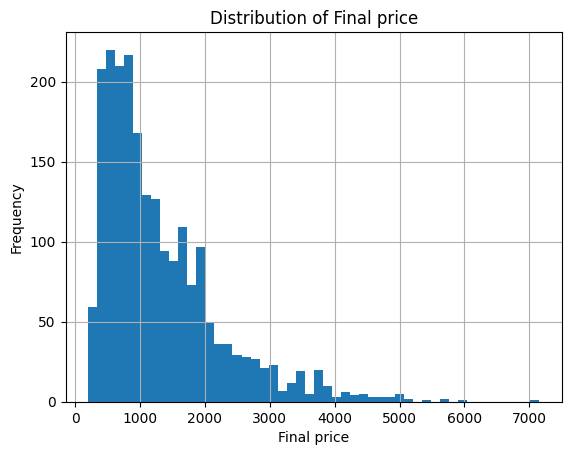

In [169]:
# EDA
# Look at the final_price variable. Does it have a long tail? YES

print(df.final_price.describe())

# draw a histogram of the final_price column
df.final_price.hist(bins=50)
# add labels and title
plt.xlabel('Final price')
plt.ylabel('Frequency')
plt.title('Distribution of Final price')


In [104]:
# Question 1 There's one column with missing values. What is it?

df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [105]:
# Question 2 What's the median (50% percentile) for variable `'ram'`?

df[['ram']].median()

ram    16.0
dtype: float64

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [106]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

n, n_val, n_test, n_train

(2160, 432, 432, 1296)

In [107]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [108]:
df_train = df.iloc[idx[:n_train]].reset_index(drop=False)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=False)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?


In [191]:
y_train = df_train.final_price.values #np.log1p(df_train.final_price.values)
y_val = df_val.final_price.values # np.log1p(df_val.final_price.values)
y_test = df_test.final_price.values # np.log1p(df_test.final_price.values)


In [192]:
base = ['ram','storage','screen'] # 'final_price'
# Calculate the median of the 'screen' column
med_screen_size = df_train['screen'].mean()

def prepare_X(df, option):
    df_num = df[base].copy()
    if option==0:
        df_num = df_num.fillna(0)
    else:
        # Fill NaN values in the 'screen' column with the median value
        df_num['screen'] = df_num['screen'].fillna(med_screen_size)

    X = df_num.values
    return X


In [193]:
X_train = prepare_X(df_train, 0)
X_train

array([[  32. , 1000. ,   15.6],
       [   8. ,  512. ,   13.3],
       [   8. ,  512. ,   15.6],
       ...,
       [   8. ,  128. ,   15.6],
       [  16. , 1000. ,   17.3],
       [  32. , 2000. ,   16. ]])

In [194]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [195]:
w0, w = train_linear_regression(X_train, y_train)
w0, w

(663.3792792607826, array([ 38.0093441 ,   0.90355423, -31.7002009 ]))

In [196]:
X_val = prepare_X(df_val, 0)
y_pred = w0 + X_val.dot(w)


In [197]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [198]:
score_0 = rmse(y_val, y_pred)
score_0

576.1017929433108

<Axes: ylabel='Count'>

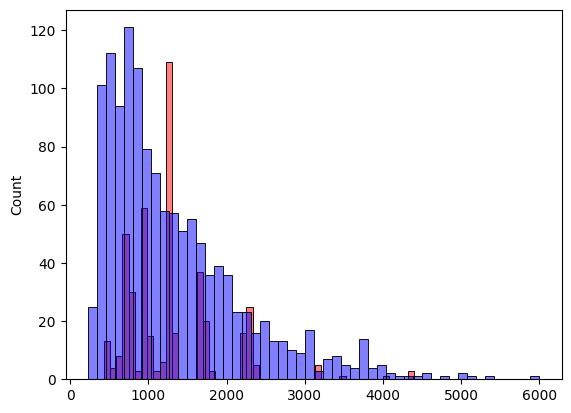

In [199]:

sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [200]:
X_train_m = prepare_X(df_train, 1)
X_train_m

array([[  32. , 1000. ,   15.6],
       [   8. ,  512. ,   13.3],
       [   8. ,  512. ,   15.6],
       ...,
       [   8. ,  128. ,   15.6],
       [  16. , 1000. ,   17.3],
       [  32. , 2000. ,   16. ]])

In [201]:
w0, w = train_linear_regression(X_train_m, y_train)
w0, w

(696.9407685448982, array([ 38.06294325,   0.90511236, -34.00244389]))

In [202]:
X_val = prepare_X(df_val, 1)
y_pred = w0 + X_val.dot(w)

score_m = rmse(y_val, y_pred)
score_m

575.7521638231043

In [203]:
score_0, score_m

(576.1017929433108, 575.7521638231043)

In [204]:
round(score_0, 2), round(score_m, 2)

(576.1, 575.75)

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.


In [205]:
# Define the list of regularization parameters (r) to try
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

In [206]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [207]:
# Fill missing values with 0
df_val = df_val.fillna(0)
X_val = prepare_X(df_val, 0)

In [208]:
best_r = None
best_rmse = 100000
for r in r_values:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w0 + X_val.dot(w)
    rmse_r = rmse(y_val, y_pred)
    print(r, w0, round(rmse_r,4))
    if rmse_r < best_rmse:
        best_r = r
        best_rmse = rmse_r

print(f"\nBest r: {best_r}, best RMSE: {round(best_rmse, 2)}")

0 663.3792792607826 576.1018
0.01 662.5630182608772 576.1035
0.1 655.3061905406176 576.1189
1 590.6272765486219 576.2999
5 410.6379702609168 577.2151
10 297.4844588709436 578.1001
100 50.557282845741426 580.8884

Best r: 0, best RMSE: 576.1


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- 29.176
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [239]:
idx = np.arange(n)
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
all_scores = []

for seed in seed_values:

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train: n_train + n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train + n_val:]].reset_index(drop=True)

    y_train = df_train.final_price.values #np.log1p(df_train.final_price.values)
    y_val = df_val.final_price.values # np.log1p(df_val.final_price.values)
    y_test = df_test.final_price.values # np.log1p(df_test.final_price.values)

    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)

    all_scores.append(score)

    print(seed, w0, score)

print("\nAll scores: ", all_scores)
std = np.std(all_scores)
print("Standard Deviation:", std, "Rounded Std:", round(std, 3))

0 547.5696230186684 565.4520868771027
1 594.41974279991 636.7985423056726
2 649.4685454769078 588.9558697907962
3 571.945904011273 597.8148920012521
4 629.3882030645109 571.962791511102
5 580.7647373330074 573.2383256618949
6 783.7683689905917 647.3438328407208
7 376.4358600624204 550.4398184485952
8 572.8852361198617 587.333503616991
9 663.3792792607826 576.1017929433108

All scores:  [565.4520868771027, 636.7985423056726, 588.9558697907962, 597.8148920012521, 571.962791511102, 573.2383256618949, 647.3438328407208, 550.4398184485952, 587.333503616991, 576.1017929433108]
Standard Deviation: 29.17649125829274 Rounded Std: 29.176


### Question 6

    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?

Options:

    598.60
    608.60
    618.60
    628.60


In [244]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_trainval = df.iloc[idx[:n_train + n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train + n_val:]].reset_index(drop=True)

y_trainval = df_trainval.final_price.values # np.log1p(df_trainval.final_price.values)
y_test = df_test.final_price.values # np.log1p(df_test.final_price.values)

X_trainval = prepare_X(df_trainval, 0)
w0, w = train_linear_regression_reg(X_trainval, y_trainval, r=0.001)

X_test = prepare_X(df_test, 0)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)

print(score)

608.609982204956
